# Plant Seedings
https://www.kaggle.com/c/plant-seedlings-classification

In [1]:
# Shell script for preparing data
# cd data
# mkdir plantseedings
# cd plantseedings
# kg download -u <username> -p <password> -c plant-seedlings-classification -f sample_submission.csv.zip
# kg download -u <username> -p <password> -c plant-seedlings-classification -f test.zip
# kg download -u <username> -p <password> -c plant-seedlings-classification -f train.zip

# unzip -q sample_submission.csv.zip
# unzip -q test.zip
# unzip -q train.zip

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from fastai.imports import *

In [4]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

# Build the model

Since the evaluation metric of the competition is mean f1 score, let's add it to our metrics list.

In [5]:
from sklearn.metrics import f1_score

def f1(preds, targs):
    return f1_score(targs, np.argmax(preds, axis=1), average='micro')
    
metrics = [f1]

In [6]:
PATH= "data/plantseedings/"
sz = 224
bs = 64

#  Build model

In [21]:
arch = resnext101_64#resnet50
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.1)

data = ImageClassifierData.from_paths(PATH, bs=bs, tfms=tfms, trn_name="train", 
                                      val_name="train", # Have to change this!!!!! It's a sin I'm committing!
                                      test_name="test")

In [22]:
torch.manual_seed(43)
learn = ConvLearner.pretrained(arch, data, precompute=True, metrics=metrics)

100%|██████████| 13/13 [00:04<00:00,  3.10it/s]


In [23]:
lrf = learn.lr_find()

A Jupyter Widget

 91%|█████████ | 68/75 [00:01<00:00, 50.46it/s, loss=15.8]


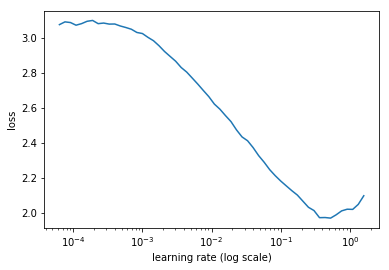

In [24]:
learn.sched.plot()

In [25]:
learn.fit(0.05, 5)

A Jupyter Widget

[ 0.       0.90748  0.41477  0.8581 ]                      
[ 1.       0.60327  0.25129  0.91071]                      
[ 2.       0.49486  0.20808  0.92967]                      
[ 3.       0.40317  0.13729  0.95551]                      
[ 4.       0.32004  0.14135  0.95634]                      



In [ ]:
[ 0.       1.06297  0.50921  0.82259]                     
[ 1.       0.76098  0.32987  0.89571]                      
[ 2.       0.58301  0.27624  0.9053 ]                      
[ 3.       0.44985  0.25507  0.91777]                      
[ 4.       0.40732  0.17471  0.93872]    

In [26]:
learn.precompute = False

In [27]:
learn.lr_find()

A Jupyter Widget

 92%|█████████▏| 69/75 [00:22<00:01,  3.01it/s, loss=2.86] 

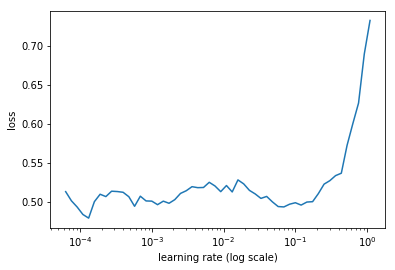

In [28]:
learn.sched.plot()

In [29]:
learn.fit(1e-3, 5, cycle_len=1)

A Jupyter Widget


 33%|███▎      | 25/75 [00:09<00:19,  2.60it/s, loss=0.432]

 35%|███▍      | 26/75 [00:09<00:18,  2.61it/s, loss=0.427]

Exception in thread Thread-37:
Traceback (most recent call last):
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

Exception in thread Thread-38:
Traceback (most recent call last):
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeErro

[ 0.       0.49299  0.11805  0.96155]                      
[ 1.       0.47167  0.10437  0.96655]                      
[ 2.       0.43692  0.09596  0.96967]                      
[ 3.       0.43161  0.09101  0.97051]                      
[ 4.       0.43599  0.08961  0.9728 ]                      



In [30]:
learn.save("resnext101_64__224__1")

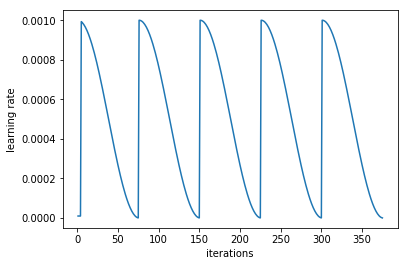

In [31]:
learn.sched.plot_lr()

In [35]:
learn.load("resnext101_64__224__1")

# Increase image size

In [36]:
def get_data(sz, bs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.1)
    data = ImageClassifierData.from_paths(PATH, bs=bs, tfms=tfms, trn_name="train", 
                                          val_name="train", # Have to change this!!!!! It's a sin I'm committing!
                                          test_name="test")
    return data if sz < 300 else data.resize(299, 'tmp')

In [37]:
data = get_data(299, 64)

In [38]:
learn.fit(1e-3, 3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

[ 0.       0.44318  0.09162  0.97259]                      
[ 1.       0.40162  0.08607  0.97384]                      
[ 2.       0.39043  0.08832  0.97217]                      
[ 3.       0.41544  0.08262  0.97467]                      
[ 4.       0.38428  0.0815   0.97613]                      
[ 5.       0.36024  0.08149  0.9753 ]                      
[ 6.       0.39141  0.07912  0.97759]                      



# Predict on test set

In [39]:
preds, _ = learn.TTA(is_test=True)

In [40]:
final_preds = [data.classes[x] for x in np.argmax(preds, axis=1)]
fnames = [x.split("/")[1] for x in data.test_ds.fnames]

In [41]:
final = pd.DataFrame({'file': fnames, 'species': final_preds})

f = "submit2.csv"
final.to_csv(f"{PATH}{f}", index=False)

from IPython.display import FileLink
FileLink(f"{PATH}{f}")

/home/ubuntu/fastai/courses/dl1/data/plantseedings/submit2.csv